In [1]:
import pandas as pd
import numpy as np
import utilities.misc as um
import utilities.constants as uc
import pdb
from blp.bdx import bdh,bdp,bds
from fql.fql import Factset_Query
from fql.util import bbg_to_fs, fs_to_bbg,fql_date
from blp.util import get_bbg_usual_col, group_marcap,get_ashare_exchange,load_compo
import feather
import os

#plotly related
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities.display as ud

from datetime import datetime

import utilities.mathematics as umath

from joblib import load, dump

import matplotlib.pyplot as plt



from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor



from backtester.backtester import BACKTESTER

# Coding of backtester
- think of weight as notional, then short is just negative notional on some return stream
- assume no leverage is easier for LS
- to reconcile no-leverage vs. 1x leverage (the existing backtester), do diff (not pct_chg), x2, cumsum (not cumprod)
    - this is because at stock level return is compounded but at port level the compounded ret are summed
- the above reconciliation will not work once you rebalance (because the difference is compounded over time)

In [2]:
# load some data
path="C:\\Users\\davehanzhang\\python_data\\connect\\ccass_all\\"
px=feather.read_dataframe(path+'px_data.feather').set_index(['date','ticker'])['PX_LAST'].unstack()
ret=px.pct_change().fillna(0)

bt=BACKTESTER(path,bps=0)


In [3]:
shorts=['700 HK Equity','1299 HK Equity','3690 HK Equity','1810 HK Equity']
longs=['883 HK Equity','2357 HK Equity','3333 HK Equity','728 HK Equity']



signals=pd.concat([px[longs].applymap(lambda x: 1/len(longs)),
                   px[shorts].applymap(lambda x: -1/len(shorts)),
                  ],axis=1).resample('BM').last().iloc[:-1]
                   
feather.write_dataframe(signals.reset_index(),path+'signals.feather')
feather.write_dataframe(px.reset_index(),path+'mkt.feather')
feather.write_dataframe(px.reset_index(),path+'vwap.feather')

In [4]:
bt.load_data(signal_name='signals')
bt.mkt['cash']=1
bt.vwap['cash']=1


In [5]:
perf_pct,perf_abs,shares_overtime,to,hlds=bt.run_with_weight(signals.index[0],len(signals.columns),'cash',signals,normalize_wgt=False)

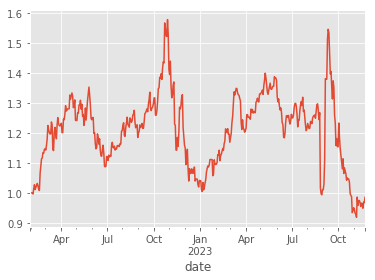

In [6]:
perf_pct['l-mkt_net'].plot()

In [7]:
# a quick backtester coding

signals_no_leverage=signals/2
last_value=signals_no_leverage.abs().sum(1)[0]

collector=[]
rebal_value=pd.Series(index=signals_no_leverage.index,data=np.nan)
for i,dt_i in enumerate(signals_no_leverage.index):
    try:
        dt_next_i=signals_no_leverage.index[i+1]
    except:
        dt_next_i=bt.mkt.index[-1]
    
    wgt_i=signals_no_leverage.loc[dt_i]
    port_i=(px.loc[dt_i:dt_next_i][signals_no_leverage.columns].pct_change().fillna(0)+1).cumprod().multiply(wgt_i,axis='columns')
    
    ret_cumu_i=last_value*(port_i.sum(1)+1)
    last_value=ret_cumu_i.iloc[-1]
    # if i==1:
    #     check_1=port_i
    #     asdf
    try:
        rebal_value.at[dt_next_i]=(signals.loc[dt_next_i]*last_value-port_i.iloc[-1]).abs().sum()
    except:
        pass
    collector.append(ret_cumu_i)

In [8]:
# # a quick backtester coding

# signals_no_leverage=signals
# last_value=1#signals_no_leverage.abs().sum(1)[0]

# collector=[]
# rebal_value=pd.Series(index=signals_no_leverage.index,data=np.nan)
# for i,dt_i in enumerate(signals_no_leverage.index):
#     try:
#         dt_next_i=signals_no_leverage.index[i+1]
#     except:
#         dt_next_i=bt.mkt.index[-1]
    
#     wgt_i=signals_no_leverage.loc[dt_i]
#     port_i=(px.loc[dt_i:dt_next_i][signals_no_leverage.columns].pct_change().fillna(0)+1).cumprod().multiply(wgt_i,axis='columns')
    
#     ret_cumu_i=last_value*(port_i.sum(1)+1) # the issue is about +1 here, it's a bit confusing here.
#     last_value=ret_cumu_i.iloc[-1]
#     # if i==1:
#     #     check_2=port_i
#     #     asdf
#     try:
#         rebal_value.at[dt_next_i]=(signals.loc[dt_next_i]*last_value-port_i.iloc[-1]).abs().sum()
#     except:
#         pass
#     collector.append(ret_cumu_i)

In [9]:
# (check_1.sum(1)+1).pct_change()/(check_2.sum(1)+1).pct_change()

In [10]:
# check_1.sum(1).diff()/check_2.sum(1).diff()

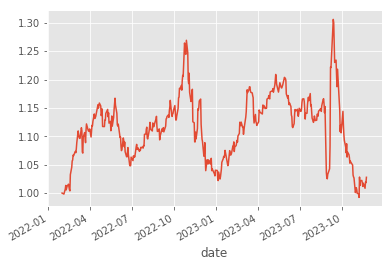

In [11]:
pd.concat(collector).reset_index().groupby('date').last()[0].plot()

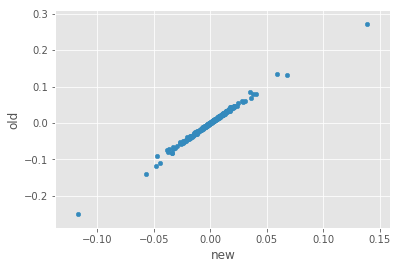

In [12]:
comp=pd.concat([perf_pct['l-mkt_net'].rename('old'),
               pd.concat(collector).reset_index().groupby('date').last()[0].rename('new')
               ],axis=1)
comp.dropna().diff().plot(kind='scatter',x='new',y='old')

In [13]:
comp.dropna().diff().pct_change(axis=1)['new'].to_frame().style#.plot()

,new
date,
2022-01-31 00:00:00,nan
2022-02-04 00:00:00,-0.500000
2022-02-07 00:00:00,-0.500000
2022-02-08 00:00:00,-0.500000
2022-02-09 00:00:00,-0.500000
2022-02-10 00:00:00,-0.500000
2022-02-11 00:00:00,-0.500000
2022-02-14 00:00:00,-0.500000
2022-02-15 00:00:00,-0.500000


# Performance stats (with tracking error so important)
- sharpe
- sortino
- mdd
- VaR 95%
- expected short fall 5%
- tracking error (ex ante vs. ex post)
    - ex ante: expected tracking error, quad_form  (wgt_active.T @ cov @ wgt_active)
    - ex ante tracking error breakdown (by GPT, can verify later): 
        - CTTE= wgt_active * (wgt_active.T @ Cov).T 

    - ex post: realized tracking error, stdev of  (port return - benchmark return)


In [14]:
perf_i=perf_pct['l-mkt_net']
ret_i=perf_i.pct_change()
dc_year=260
rf=1/100/dc_year


# sharpe
res=(ret_i.mean()-rf)/ret_i.std()*np.sqrt(dc_year)
print ('sharpe is %s' % (res) )

# sortino
res=(ret_i.mean()-rf)/ret_i[ret_i<0].std()*np.sqrt(dc_year)
print ('sortino is %s' % (res) )

# mdd (can do pd.rolling.apply to calculate rolling drawdown)
res=(perf_i/np.maximum.accumulate(perf_i)-1).min()
print ('mdd is %s' % (res) )

# var95
res=np.percentile(ret_i.dropna(), 5) 
print ('var95 is %s' % (res) )

# ES
var=np.percentile(ret_i.dropna(), 5) 
res=ret_i[ret_i<var].mean()
print ('ES is %s' % (res))

sharpe is 0.17258917562840767
sortino is 0.2189298133143124
mdd is -0.41748606605414873
var95 is -0.04003431484028912
ES is -0.06152197079207459


# Some matrix operation
- var calculation
- linear regression
- attribution

# - cov/corr correlation

In [15]:
# var calculation 

ret=px.iloc[::5,::50].pct_change().fillna(0)

# using numpy directly
cov=ret.cov()
corr=ret.corr()
var=np.diagonal(cov)

# code yourself (calculate the centered return)
n=len(ret)
ret_c=ret-ret.mean()
cov_self=(ret_c.T @ ret_c)*(1/(n-1)) # divided by n-1 as this is sample covariancn


# get correlation
corr_diag=np.diag(np.sqrt(np.diag(cov_self)))
corr_diag_inv=np.linalg.inv(corr_diag)
corr_self=corr_diag_inv @ cov_self @ corr_diag_inv 

In [16]:
corr.sum().sum()

217.5777336952652

In [17]:
corr_self.sum().sum()

217.5777336952652

In [18]:
cov.sum().sum()

3.8681127346203237

In [19]:
cov_self.sum().sum() # some rounding error

3.8681127346203237

# - Linear regression (statsmodels and sklearn)

In [20]:
# linear regression (coefficients, p-value/t-stats, ANOVA)

# raw data
ret=px.iloc[::5,:5].fillna(0).pct_change().fillna(0)
ret.columns=['y','x1','x2','x3','x4']
y='y'
xs=ret.columns.drop(y).tolist()


# using sklearn + statsmodels
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(ret[xs],ret[y])

print ('Sklean results')
print ('coeffs are: %s' % (lm.coef_))
print ('intercept is: %s' % (lm.intercept_))

# using statsmodels
import statsmodels.api as sm
Xs=sm.add_constant(ret[xs])
model=sm.OLS(ret[y],Xs)
results=model.fit()

print ('\nStatsmodels results')
print ('parameters are\n%s' % (results.params))
print ('p-values are\n%s' % (results.pvalues))
print ('t-stats are\n%s' % (results.tvalues))
print ('rsquared are\n%s' % (results.rsquared)) # can also do results.ess/(results.ssr+results.ess) ess is explained sum of squared
print ('sum of residual squared is %s' % (results.mse_resid))

print(results.summary())
results.predict([Xs.iloc[10,:]])

Sklean results
coeffs are: [ 0.49125974 -0.03573812  0.12997837 -0.01577567]
intercept is: 1.602907436027909e-05

Statsmodels results
parameters are
const    0.000016
x1       0.491260
x2      -0.035738
x3       0.129978
x4      -0.015776
dtype: float64
p-values are
const    9.952194e-01
x1       9.073776e-10
x2       3.382911e-01
x3       1.062180e-01
x4       4.171865e-01
dtype: float64
t-stats are
const    0.006009
x1       6.853497
x2      -0.962731
x3       1.631976
x4      -0.815108
dtype: float64
rsquared are
0.3719363527385515
sum of residual squared is 0.0006458059080833557
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     13.18
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.80e-08
Time:          

array([-0.00686781])

In [21]:
sm.OLS(ret[y],Xs).fit().params

const    0.000016
x1       0.491260
x2      -0.035738
x3       0.129978
x4      -0.015776
dtype: float64

# - code the linear regression yourself
- just for parameters

In [22]:
ret=px.iloc[::5,:5].fillna(0).pct_change().fillna(0)
ret.columns=['y','x1','x2','x3','x4']
ret['const']=1

Xs=ret.drop('y',1)
y=ret['y']

from numpy.linalg import inv

params=inv(Xs.T @ Xs) @ Xs.T @ y

In [ ]:
# for weighted operation you can do the below adjustment

# # Calculate weighted design matrix
# Xw = X @ W

# # Calculate weighted target variable
# yw = y * weights

In [23]:
params

0    0.491260
1   -0.035738
2    0.129978
3   -0.015776
4    0.000016
dtype: float64

# - attribution analysis

In [2]:
# Portfolio risk
'''
X factor exposure of individual stock (n x m)
P portfolio with weight (n x 1)
F_var cov of factor (m x m)
D specific risk diagonal (n x n)

beta=X.T @ P (m x 1)
CTC=beta * (beta.T @ F_var).T (m x 1) (CTC is contribution to covariance)
CTC[specific]= P.T @ D @ P


For cov of individual stocks
Cov = X @ F_var @ X.T + D (n x n)

For cov of portfolio of stocks (weighted)
P_d=np.diag(P)
Cov_P=P_d @ Cov @ P_d


Sum of CTC is equal to the sum of COV
'''

'\nX factor exposure of individual stock (n x m)\nP portfolio with weight (n x 1)\nF_var cov of factor (m x m)\nD specific risk diagonal (n x n)\n\nbeta=X.T @ P (m x 1)\nCTC=beta * (beta.T @ F_var).T (m x 1) (CTC is contribution to covariance)\nCTC[specific]= P.T @ D @ P\n\n\nFor cov of individual stocks\nCov = X @ F_var @ X.T + D (n x n)\n\nFor cov of portfolio of stocks (weighted)\nP_d=np.diag(P)\nCov_P=P_d @ Cov @ P_d\n\n\nSum of CTC is equal to the sum of COV\n'

In [47]:
# assuming 3 stocks and 2 factors

X=np.array([[0.9,0.8],[0.5,-0.2],[-1.3,0.2]])
P=np.array([0.3,0.4,0.3])
F_var=np.array([[0.25,0.3],[0.3,0.68]])
D=np.diag(np.array([0.24,0.25,0.32]))

# CTC approach
beta=X.T @ P #(m x 1)
CTC=beta * (beta.T @ F_var).T #(m x 1)
CTC_specific= P.T @ D @ P
var_total=np.array(list(CTC)+[CTC_specific])

# weighted portfolio approach
Cov = X @ F_var @ X.T + D #(n x n)
P_d=np.diag(P)
Cov_P=P_d @ Cov @ P_d

In [48]:
var_total.sum()

0.135472

In [49]:
Cov_P.sum().sum()

0.135472

# - pyportfolio optimization
everything centered around EfficientFrontier, I won't be coding any solver, I'll give up is I'm asked such questions

In [25]:
import pypfopt
pypfopt.__version__

from pypfopt import EfficientFrontier
from pypfopt import constraints

ImportError: cannot import name 'constraints' from 'pypfopt' (C:\Users\davehanzhang\Anaconda3\lib\site-packages\pypfopt\__init__.py)

In [ ]:
# simple version
EfficientFrontier(mu, cov)
EfficientFrontier.min_volatility()

# then you can add some constraints to formulate your objective

# risk model estimation (ex-ante, naive)
- define factor
- estimate factor cov and beta
- how to estimate stock specific risk matrix??? seems to be the variance of excess return
    - per GPT
    - In risk models like Axioma or Barra, the idiosyncratic risk matrix is typically estimated using statistical methods. One common approach is to measure the idiosyncratic volatility as the residual standard error from a time-series regression of periodic excess stock returns on the returns of a factor model3. This method essentially isolates the component of the stock’s return that cannot be explained by the common factors in the model, which is considered the idiosyncratic risk.

# pandas operation
- qcut
- groupby
- rolling
    - rolling & apply: need to make sure the fucntion returns a scalar
- transform (works better with groupby and maintains the index with the original database (well-aligned))
- operation alone row/column
- stack/unstack
- join, concat (how='left','right','outer','inner')
- datetime (resample, offset)
- sort
- find out the nlargest: nlargest

In [32]:
# do qcut based on price level
Qs=10
px_q=px.stack().rename('px').reset_index()
px_q['Q']=px_q.groupby(['date'])['px'].apply(lambda x: pd.qcut(x,Qs,labels=['Q%s' %(i+1) for i in np.arange(0,Qs,1)]))

In [33]:
px_q.groupby(['date','Q'])['px'].apply(lambda x: x.mean())

date        Q  
2022-01-03  Q1      0.057873
            Q2      0.143840
            Q3      0.252663
            Q4      0.418688
            Q5      0.726917
                     ...    
2023-11-23  Q6      1.627083
            Q7      3.020060
            Q8      5.324994
            Q9     10.415838
            Q10    60.898631
Name: px, Length: 4660, dtype: float64

In [34]:
px_q.groupby(['date','Q'])['px'].transform(lambda x: x.mean())

0          66.331713
1          66.331713
2           0.726917
3           0.418688
4           0.143840
             ...    
1201831    60.898631
1201832     3.020060
1201833    60.898631
1201834    10.415838
1201835    10.415838
Name: px, Length: 1201836, dtype: float64

In [35]:
# rolling rank is very slow
px[['700 HK Equity','1 HK Equity']].fillna(method='ffill').rolling(50).apply(lambda x: x.rank(pct=True)[-1])

ticker,700 HK Equity,1 HK Equity
date,,
2022-01-03,NaN,NaN
2022-01-04,NaN,NaN
2022-01-05,NaN,NaN
2022-01-06,NaN,NaN
2022-01-07,NaN,NaN
...,...,...
2023-11-17,0.80,0.32
2023-11-20,1.00,0.45
2023-11-21,0.97,0.48


# datatable operation

In [36]:
import datatable as dt
from datatable import f,by,sort,shift,join,ifelse
# f[:].expand({'':xxx})
# dt.qcut
# dt[:,:,sort()]
# dt.key=['','']; dt[:,:,join()]
# dt[:,f[''],by([])]
# dt[:,f[:].extend(),by()]


In [37]:
dt.time.ymd(2023,1,1)

FExpr<time.ymd(2023, 1, 1)>

# plotting (don't spend too much time on it)
- matplotlib basics
- ploty

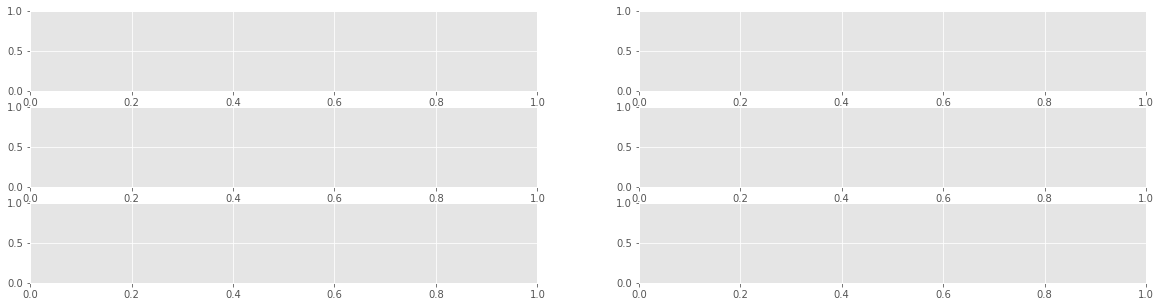

In [38]:
import matplotlib.pyplot as plt
fig, axes=plt.subplots(3,2,figsize=(20,5))
# then you can use pandas to pass over charts

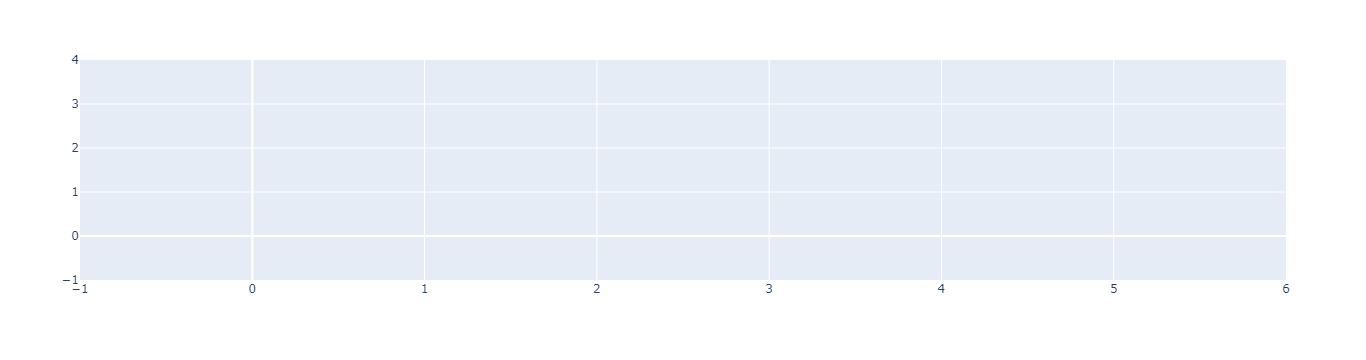

In [39]:
import plotly.express as px_p
px_p.line()
px_p.box()

# Others
- workflow automation (win32com, autoemail)
- webscraping

In [40]:
import win32com.client as wc

outlook=wc.Dispatch("Outlook.Application")
mail=outlook.CreateItem(0)
mail.To=To
if Bcc!='':
    mail.Bcc=Bcc
mail.Subject=subject_pre_fix+' '+Subject
mail.HTMLBody=Body

In [44]:
import requests
from bs4 import BeautifulSoup

session = requests.Session()
session.get()
soup = BeautifulSoup(response.content,features='lxml')

TypeError: get() missing 1 required positional argument: 'url'

# Basic python operation
- list: comprehension
- set: operation
- dict:
- loop: continue (next loop), pass (placeholder), break, enumerate
- class: basic structure, inheritance
- func (recursion)
- module
- error handling
- calling script as itself or from other place

In [87]:
# list comprehension: all the usual stuff plus the below

# zip to create 
list_a=[1,2,3]
list_b=['a','b','c']
print (list(zip(list_a,list_b)))
print (dict(zip(list_a,list_b)))

# flatten 2d to 1d (nested for loop)
list_2d=[[1,2,3],[4,5,6],[7,8,9]]
list_1d=[x for row in list_2d for x in row]
list_1d

[(1, 'a'), (2, 'b'), (3, 'c')]
{1: 'a', 2: 'b', 3: 'c'}


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [70]:
# set operation
set_1={1,2,3}
set_2=set([2,3,4])

print (set_1-set_2) # in 1 not in 2
print (set_2-set_1) # in 2 not in 1
print (set_1.union(set_2))
print (set_1.intersection(set_2))
print (set_1.symmetric_difference(set_2))

{1}
{4}
{1, 2, 3, 4}
{2, 3}
{1, 4}


In [86]:
list_b.sort(reverse=True)
print (list_b)

['c', 'b', 'a']


In [95]:
def bubble_sort(arr):
    n = len(arr)
    for i in range(n - 1):
        # Last i elements are already in place
        for j in range(n - i - 1):
            # Swap adjacent elements if they are in the wrong order
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

# Example usage
numbers = [5, 2, 8, 1, 9, 3]
bubble_sort(numbers)
print(numbers)  # Output: [1, 2, 3, 5, 8, 9]

[1, 2, 3, 5, 8, 9]


In [96]:
numbers[0],numbers[3]=numbers[3],numbers[0]

In [97]:
numbers

[5, 2, 3, 1, 8, 9]

In [98]:
class TEST():
    def __init__(self,name):
        self.name=name
    def print_name(self):
        print ('my name is %s' % (self.name))
        
dave=TEST('dave')
dave.print_name()


my name is dave


In [100]:
if __name__=='__main__':
    print ('ok')

ok


# Environment setup
- virtual env
    - conda create --name myenv
- setup path
- package installation (pip vs. conda)

# Factor definition
- Market related
    - FX beta: rs=a+b1*mkt+b2*rate
    - market beta: just CAPM
    - liquidity (vol/marcap)
    - momentum (12m-1m)
    - size: just market cap
    - volatility: just rv (to make it simple)
- Fundamental
    - value: P/B, earnings yld (eps/p)
    - leverage: debt to equity, debt to asset
    - growth: earnings growth, sales growth (regression extrapolated)
    - profitability: ROE, ROA, CF to income, Gross margin, sales to asset (turnover)
    - div yield
- then we also have sector

# Factor performance
- Japan
    - work:  div, value
    - not work: mom, high vol, high leverage
- China A & H
    - work: momentum, revision
    - not work: size, quality
- China H:
    - work: momentum, revision
    - not work: high vol
- APAC:
    - work: revision, momentum
    - not work: high vol, large cap

# Multi-factor model
- how do you combine factor?
    - high turnover factor vs. low turnover (can downweight the high turnover one so that the monthly rebalance won't change easily)
- factor that works in different market maybe different?

# Others
- exponential weighting
- rolling window with user defined weight (rolling, apply, np.dot)
- linearly decay weight: np.linspace
- exponential decay with hl input: np.log(0.5)/hl

In [ ]:
pd.DataFrame.ewm()

In [ ]:
weight_window=[0,1,0.2,0.3,0.4]
pd.DataFrame.rolling().apply(lambda x: np.dot(x,weight_window))

In [24]:
data = {'Value': [10, 12, 15, 14, 16, 18, 20]}
df = pd.DataFrame(data)

# Define the length of the series
series_length = len(df)

weights = np.linspace(0, 1, series_length)
weights = np.where(weights < 0.5, weights * 2, (1 - weights) * 2)

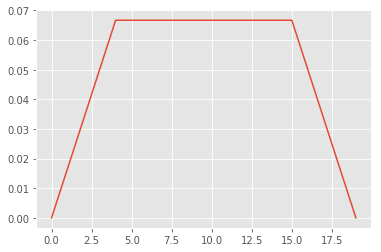

In [37]:
window_wgt=list(np.linspace(0, 1, 5))+[1 for i in np.arange(0,10)]+list(np.linspace(1, 0, 5))
window_wgt=np.array(window_wgt)
pd.Series(window_wgt/window_wgt.sum()).plot()

In [4]:
N = 6

# Define the half-life
hf = 2

# Calculate the decay factor from the half-life
decay_factor = np.log(0.5) / hf 

# Calculate the exponentially decayed weights
weights = np.exp(decay_factor * np.arange(N))
weights /= np.sum(weights)

print(weights)

[0.33473511 0.23669346 0.16736755 0.11834673 0.08368378 0.05917337]


In [5]:
decay_factor

-0.34657359027997264

In [40]:
np.exp(decay_factor * np.arange(N))

array([1.        , 0.70710678, 0.5       , 0.35355339, 0.25      ,
       0.1767767 ])

In [48]:
wgt=np.linspace(0,1,num=6)
wgt/wgt.sum()

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333])

In [51]:
np.linalg.inv
np.arange
np.linspace

<function numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)>

In [59]:
decay_factor=np.log(0.5)/4

In [61]:
np.exp(decay_factor*np.arange(10))

array([1.        , 0.84089642, 0.70710678, 0.59460356, 0.5       ,
       0.42044821, 0.35355339, 0.29730178, 0.25      , 0.2102241 ])

# BBG related
- calendarization
- Annual: beat/miss/guidance alignment (important)
- Quarterly beat/miss/guidance (TODO)
- for JP, key data point would be guid fy1 beat est fy1 (guid fy1 will move to next fiscal year after annual announcement)

In [2]:
from datetime import datetime
from utilities.misc import iterate_csv,yesterday_date,today_date

ticker='9432 JP Equity'
field='BEST_NET_INCOME'
step_bday=5
output_fy=[0,1,2]
start_year=2010


end_year=today_date().year+3
years=np.arange(start_year,end_year+1)
announcement_dts=pd.DataFrame()
collector=[]
for year in years:
    res=bdp([ticker],['ANNOUNCEMENT_DT'],overrides={'EQY_FUND_YEAR':year,'FUND_PER':'Y'})
    res['fy']=year
    collector.append(res)
announcement_dts=pd.concat(collector,0)
delta=announcement_dts.dropna().diff().iloc[-1].values[0]
announcement_dts=announcement_dts.set_index('fy')
announcement_dts=announcement_dts.fillna(0)

for i,fy in enumerate(announcement_dts.index):
    if announcement_dts.loc[fy]['ANNOUNCEMENT_DT']==0:
        try:
            announcement_dts.at[fy,'ANNOUNCEMENT_DT']=announcement_dts.loc[fy-1]['ANNOUNCEMENT_DT']+delta
        except KeyError:
            continue

announcement_dts=announcement_dts[announcement_dts['ANNOUNCEMENT_DT']!=0]

announcement_dts['ANNOUNCEMENT_DT']=pd.to_datetime(announcement_dts['ANNOUNCEMENT_DT'])
announcement_dts=announcement_dts.reset_index().set_index('ANNOUNCEMENT_DT')
announcement_dts_d=announcement_dts.resample('D').last().fillna(method='bfill') # need bfill!
#get the fiscal year 20xx EPS estimate
all_ts=pd.DataFrame()
collector=[]
for year in years:
    try:
        fperiod='%sY' % (year-2000)
        ts=bdh([ticker],[field],datetime(2000,1,1),today_date(),overrides={'BEST_FPERIOD_OVERRIDE':fperiod}).loc[ticker]
        ts['fy']=year
        ts['next_fy_asof_now']=announcement_dts_d['fy'] # this ensures when the date moves to next fy the fy column changes accordingly
        ts=ts.resample('B').last().fillna(method='ffill')
        ts['%s_%s_revision' % (field,step_bday)]=ts[field].pct_change(step_bday)
        collector.append(ts)
    except:
        print ('No data for %s on FY %s' % (ticker,year))
all_ts=pd.concat(collector,0)
output=all_ts.dropna().copy()
output['fy_rel']=output['fy']-output['next_fy_asof_now']
output=output.reset_index().set_index(['date','fy_rel'])
output_level=output.reset_index().groupby(['date','fy_rel']).mean().sort_index()[field].unstack()[output_fy]
output_revision=output.reset_index().groupby(['date','fy_rel']).mean().sort_index()['%s_%s_revision' % (field,step_bday)].unstack()[output_fy]

In [54]:
# beat/miss/estimate/reported/guidance alignment
# need to be careful about the missing guidance data
# need to align data point by checking for same year month
# also note the conservative guidance vs. estimate
# maybe not to ffill current guidance data so that we can track guidance upgrade/downgrade (guidance momentum)

# can also add stdev

ticker='7267 JP Equity'

field_dict={
            'est':'BEST_NET_INCOME',
            'rpt':'IS_COMP_NET_INCOME_ADJUST',
            'guid':'CEST_NETINCME_G',
           }
fy=2022
fperiod='%sY' % (fy-2000)
fperiod_next='%sY' % (fy-2000+1)

ts=bdh([ticker],[field_dict['est'],field_dict['guid']],datetime(2000,1,1),um.today_date(),overrides={'BEST_FPERIOD_OVERRIDE':fperiod})
ts=ts.loc[ticker].fillna(method='ffill').resample('B').last().fillna(method='ffill')#.plot()

rpt_stats=bdp([ticker],['ANNOUNCEMENT_DT',field_dict['rpt']],overrides={'EQY_FUND_YEAR':fy,'FUND_PER':'Y'})

ts_next=bdh([ticker],[field_dict['guid']],datetime(2000,1,1),um.today_date(),overrides={'BEST_FPERIOD_OVERRIDE':fperiod_next})

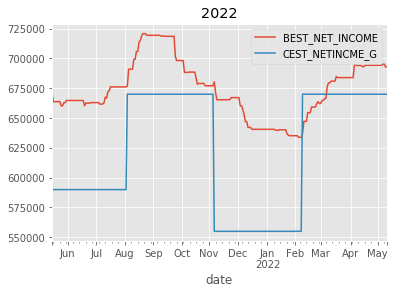

In [59]:
ts.dropna().plot(title=fy)

In [60]:
rpt_stats

,ANNOUNCEMENT_DT,IS_COMP_NET_INCOME_ADJUST
7267 JP Equity,2022-05-13,707067


In [61]:
ts.dropna().tail()

,BEST_NET_INCOME,CEST_NETINCME_G
date,,
2022-05-05,694302.286,670000.0
2022-05-06,695254.667,670000.0
2022-05-09,695254.667,670000.0
2022-05-10,692894.286,670000.0
2022-05-11,692872.333,670000.0


In [62]:
ts_next

CEST_NETINCME_G
ticker         date                       
7267 JP Equity 2022-05-13         710000.0
               2022-08-10         710000.0
               2022-11-09         725000.0
               2023-02-10         725000.0